### Functional API

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
inputs = keras.Input(shape=(3,), name='my_input')
features = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10, activation='softmax')(features)
model = keras.Model(inputs=inputs, outputs=outputs)

2022-05-17 08:26:13.400441: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
inputs.shape

TensorShape([None, 3])

In [4]:
inputs.dtype

tf.float32

In [5]:
features.shape

TensorShape([None, 64])

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


Multi-input model

In [7]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name='title')
text_body = keras.Input(shape=(vocabulary_size,), name='text_body')
tags = keras.Input(shape=(num_tags,), name='tags')

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation='relu')(features)

priority = layers.Dense(1, activation='sigmoid', name='priority')(features)
department = layers.Dense(num_departments, activation='softmax', name='department')(features)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 10000)]      0           []                               
                                                                                                  
 text_body (InputLayer)         [(None, 10000)]      0           []                               
                                                                                                  
 tags (InputLayer)              [(None, 100)]        0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 20100)        0           ['title[0][0]',                  
                                                                  'text_body[0][0]',        

Training a model by providing lists of input and target arrays

In [9]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer='rmsprop',
              loss=['mean_squared_error', 'categorical_crossentropy'],
              metrics=[['mean_absolute_error'],['accuracy']])
model.fit([title_data, text_body_data, tags_data],[priority_data,department_data], epochs=1)
model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 [==============================] - 1s 6ms/step - loss: 16.5486 - priority_loss: 0.3477 - department_loss: 16.2010 - priority_mean_absolute_error: 0.5142 - department_accuracy: 0.0789


Training a model by providing dicts of input & target arrays

In [10]:
model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          {"priority": priority_data, "department": department_data},
          epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               {"priority": priority_data, "department": department_data})
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 5ms/step - loss: 52.2364 - priority_loss: 0.3477 - department_loss: 51.8887 - priority_mean_absolute_error: 0.5142 - department_accuracy: 0.5680


In [11]:
keras.utils.plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [13]:
model.layers

In [ ]:
model.layers[3].input

Creating new model by reusing intermediate layer outputs

In [14]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation='softmax', name='difficulty')(features)

new_model = keras.Model(inputs = [title, text_body, tags],
                       outputs = [priority, department, difficulty])

Subclassed Model

In [15]:
class CustomerTicketModel(keras.Model):

    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation='relu')
        self.priority_scorer = layers.Dense(1, activation='sigmoid')
        self.department_classifier = layers.Dense(
            num_departments, activation='softmax')

    def call(self, inputs):
        title = inputs['title']
        text_body = inputs['text_body']
        tags = inputs['tags']

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

In [16]:
model = CustomerTicketModel(num_departments=4)

priority, department = model(
    {'title': title_data, 'text_body': text_body_data, 'tags': tags_data})

In [17]:
model.compile(optimizer='rmsprop',
              loss=['mean_squared_error', 'categorical_crossentropy'],
              metrics=[['mean_absolute_error'], ['accuracy']])
model.fit({'title': title_data,
           'text_body': text_body_data,
           'tags': tags_data},
          [priority_data, department_data],
          epochs=1)
model.evaluate({'title': title_data,
                'text_body': text_body_data,
                'tags': tags_data},
               [priority_data, department_data])
priority_preds, department_preds = model.predict({'title': title_data,
                                                  'text_body': text_body_data,
                                                  'tags': tags_data})

40/40 [==============================] - 0s 6ms/step - loss: 14.2736 - output_1_loss: 0.3477 - output_2_loss: 13.9259 - output_1_mean_absolute_error: 0.5142 - output_2_accuracy: 0.5672


### Mixing and matching different components

Functional model including subclasses

In [18]:
class Classifier(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = 'sigmoid'
        else:
            num_units = num_classes
            activation = 'softmax'
        self.dense = layers.Dense(num_units, activation=activation)

    def call(self, inputs):
        return self.dense(inputs)

inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation='relu')(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

Subclassed model including Functional model

In [19]:
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation='sigmoid')(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation='relu')
        self.classifier = binary_classifier

    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

model = MyModel()

### Using built-in training and evaluation loops

In [21]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28*28,))
    features = layers.Dense(512, activation='relu')(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation='softmax')(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28)).astype('float32') / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2967 - accuracy: 0.9117 - val_loss: 0.1441 - val_accuracy: 0.9575
Epoch 2/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1645 - accuracy: 0.9540 - val_loss: 0.1219 - val_accuracy: 0.9679
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.1028 - accuracy: 0.9735


Writing your own metrics

In [22]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name='rmse', **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name='mse_sum', initializer='zeros')
        self.total_samples = self.add_weight(
            name='total_samples', initializer='zeros', dtype='int32')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [24]:
model = get_mnist_model()
model.compile(optimizer='rmsprop',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy', RootMeanSquaredError()])
model.fit(train_images,train_labels,epochs=3, validation_data=(val_images,val_labels))
test_metrics = model.evaluate(test_images,test_labels)

Epoch 1/3
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2919 - accuracy: 0.9145 - rmse: 7.1840 - val_loss: 0.1599 - val_accuracy: 0.9538 - val_rmse: 7.3601
Epoch 2/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1622 - accuracy: 0.9535 - rmse: 7.3569 - val_loss: 0.1299 - val_accuracy: 0.9633 - val_rmse: 7.4031
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.1016 - accuracy: 0.9738 - rmse: 7.4315


Using Callback argument in the fit() method

In [26]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath='checkpoint_path.keras',
    monitor='val_loss',
    save_best_only=True,
    )
]
model = get_mnist_model()
model.compile(optimizer='rmsprop',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.fit(train_images,train_labels,
         epochs=10, callbacks=callbacks_list,
         validation_data=(val_images,val_labels))

Epoch 1/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.2984 - accuracy: 0.9111 - val_loss: 0.1478 - val_accuracy: 0.9577
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1646 - accuracy: 0.9536 - val_loss: 0.1170 - val_accuracy: 0.9681
Epoch 3/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1393 - accuracy: 0.9624 - val_loss: 0.1129 - val_accuracy: 0.9718
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1245 - accuracy: 0.9672 - val_loss: 0.1158 - val_accuracy: 0.9727
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1187 - accuracy: 0.9699 - val_loss: 0.1092 - val_accuracy: 0.9737
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1134 - accuracy: 0.9736 - val_loss: 0.1086 - val_accuracy: 0.9767
Epoch 7/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1049 - accuracy: 0.9755 - val_loss: 0.1057 - val_accura

Writing your own callbacks

In [27]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

Epoch 1/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.2931 - accuracy: 0.9131 - val_loss: 0.1573 - val_accuracy: 0.9575
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1685 - accuracy: 0.9533 - val_loss: 0.1295 - val_accuracy: 0.9651
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1389 - accuracy: 0.9627 - val_loss: 0.1179 - val_accuracy: 0.9708
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1296 - accuracy: 0.9669 - val_loss: 0.1118 - val_accuracy: 0.9738
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1141 - accuracy: 0.9710 - val_loss: 0.1126 - val_accuracy: 0.9741
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1107 - accuracy: 0.9730 - val_loss: 0.1102 - val_accuracy: 0.9768
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1069 - accuracy: 0.9752 - val_loss: 0.1161 - val_accurac

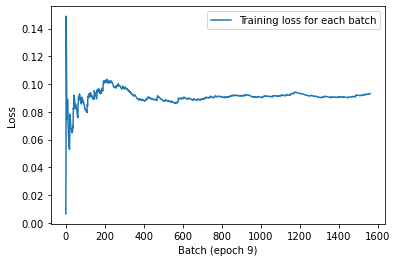

In [28]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))

Monitoring and visualization with Tensorboard

In [29]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

tensorboard = keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_log_dir",
)
model.fit(train_images, train_labels,
          epochs=10,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

2022-05-17 19:42:11.442720: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at summary_kernels.cc:65 : PERMISSION_DENIED: /full_path_to_your_log_dir; Read-only file system


PermissionDeniedError: /full_path_to_your_log_dir; Read-only file system [Op:CreateSummaryFileWriter]

In [30]:
%load_ext tensorboard
%tensorboard --logdir /full_path_to_your_log_dir

### Writing your own training and evaluation loops

In [31]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
metric.update_state(targets, predictions)
current_result = metric.result()
print(f'result: {current_result:.2f}')

result: 1.00


In [32]:
values = [0, 1, 2, 3, 4]
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)
print(f'Mean of values: {mean_tracker.result():.2f}')

Mean of values: 2.00


Writing step-by-step training loop

In [33]:
model = get_mnist_model()

loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
loss_tracking_metric = keras.metrics.Mean()

def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs['loss'] = loss_tracking_metric.result()
    return logs

In [34]:
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()

In [35]:
training_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3
for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f'Results at the end of epoch {epoch}')
    for key, value in logs.items():
        print(f'...{key}: {value:.4f}')

Results at the end of epoch 0
...sparse_categorical_accuracy: 0.9138
...loss: 0.2891
Results at the end of epoch 1
...sparse_categorical_accuracy: 0.9546
...loss: 0.1665
Results at the end of epoch 2
...sparse_categorical_accuracy: 0.9625
...loss: 0.1409


In [37]:
%%time
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs['val_' + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs['val_loss'] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print('Evaluation results:')
for key, value in logs.items():
    print(f'...{key}: {value:.4f}')

Evaluation results:
...val_sparse_categorical_accuracy: 0.9669
...val_loss: 0.1325
CPU times: user 2.13 s, sys: 77.8 ms, total: 2.21 s
Wall time: 1.99 s


Make it fast with tf.function

In [38]:
%%time
@tf.function
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs['val_' + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs['val_loss'] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print('Evaluation results:')
for key, value in logs.items():
    print(f'...{key}: {value:.4f}')

Cause: Unable to locate the source code of <function test_step at 0x7fd5b43ad160>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function test_step at 0x7fd5b43ad160>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.au

Leveraging fit() with custom training loop